In [1]:
%load_ext autoreload
%load_ext cython
%autoreload 2
%matplotlib inline

In [2]:
%%cython --annotate

import cython
from libc.stdlib cimport malloc

cdef struct Bin:
    double left
    double right
    long count
    
cdef class Histogram:
    
    cdef:
        Bin *bins
        int n
        int max_bins
        int n_bins
        
        double min_diff
        int min_idx
        
    def __cinit__(self, long max_bins):
        self.n = 0
        self.max_bins = max_bins
        self.n_bins = 0
        self.bins = <Bin*>malloc((max_bins + 1) * sizeof(Bin))
        if self.bins == NULL:
            raise MemoryError()
        
    @cython.boundscheck(False) 
    @cython.wraparound(False)
    cpdef Histogram update(self, double x):

        self.n += 1
        
        # Insert the bin if the histogram is empty
        if self.n_bins == 0:
            self.bins[0] = Bin(x, x, 1)
            self.n_bins += 1
            return 
        
        # Bisect to find where to insert the new value
        
        cdef int where
        cdef int low 
        cdef int high
        cdef int i
        cdef int j
        
        if x < self.bins[0].left:
            where = 0
        elif x > self.bins[self.n_bins - 1].right:
            where = self.n_bins
        else:
            
            low = 0
            high = self.n_bins
            
            while low < high:
                where = (low + high) // 2

                if x > self.bins[where].right:
                    low = where + 1
                elif x >= self.bins[where].left:
                    break
                else:
                    high = where
        
        # Insert the new bin
        for i in range(self.n_bins + 1, where):
            self.bins[i] = self.bins[i-1]
        self.bins[where] = Bin(x, x, 1)
        self.n_bins += 1
        
        # Bins have to be merged if there are more than max_bins
        if self.n_bins == self.max_bins + 1:

            # Find the closest pair of bins
            self.min_diff = 999
            
            for i in range(0, self.n_bins - 1):
                for j in range(i + 1, self.n_bins):
                    diff = self.bins[j].right - self.bins[i].right
                    if diff < self.min_diff:
                        self.min_diff = diff
                        self.min_idx = i
                    
            # Merge the bins
            self.bins[self.min_idx].right = self.bins[self.min_idx + 1].right
            self.bins[self.min_idx].count += self.bins[self.min_idx + 1].count
            
            for i in range(self.min_idx + 1, self.n_bins - 1):
                self.bins[i] = self.bins[i+1]
            self.n_bins -= 1
            
            #self[min_idx] += self.pop(min_idx + 1)
    
    def __repr__(self):
        cdef int i
        return '\n'.join(
            f'[{self.bins[i].left:.5f}, {self.bins[i].right:.5f}]: {self.bins[i].count}'
            for i in range(self.n_bins)
        )
        
cdef Histogram hist = Histogram(5)
hist.update(1)
hist.update(2)
hist.update(3)
hist.update(3.5)
hist.update(5)
hist.update(6)
print(hist)
print(hist.n_bins, hist.max_bins)

[1.00000, 1.00000]: 1
[2.00000, 2.00000]: 1
[3.00000, 3.50000]: 2
[5.00000, 5.00000]: 1
[6.00000, 6.00000]: 1
5 5


In [3]:
import random
from creme import utils

py_hist = utils.Histogram(100)

#%timeit py_hist.update(random.random());

In [4]:
import datetime as dt
import random
import time

c_hist = Histogram(100)
total = 0

for _ in range(10000):
    x = random.random()
    tic = time.perf_counter_ns()
    c_hist.update(x)
    total += time.perf_counter_ns() - tic

print(dt.timedelta(microseconds=total / 1000))

0:00:00.066453


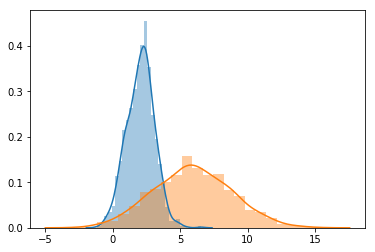

In [5]:
import seaborn as sns
import numpy as np

x1 = np.random.normal(2, 1, 1000)
x2 = np.random.normal(6, 3, 1000)

sns.distplot(x1)
sns.distplot(x2)

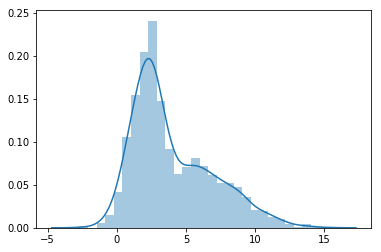

In [6]:
sns.distplot(np.concatenate((x1, x2)))

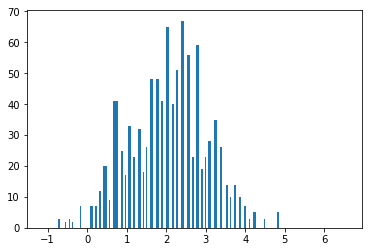

In [7]:
from creme import utils
import matplotlib.pyplot as plt

h1 = utils.Histogram(50)

for xi in x1:
    h1.update(xi)
    
plt.bar(
    x=[(b.left + b.right) / 2 for b in h1],
    height=[b.count for b in h1],
    width=[(b.right - b.left) / 2 for b in h1]
);

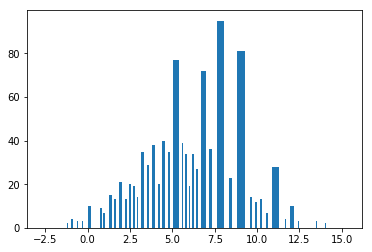

In [8]:
h2 = utils.Histogram(50)
    
for xi in x2:
    h2.update(xi)
    
plt.bar(
    x=[(b.left + b.right) / 2 for b in h2],
    height=[b.count for b in h2],
    width=[(b.right - b.left) / 2 for b in h2]
);

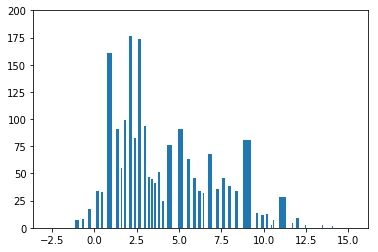

In [9]:
h = utils.Histogram(50)
    
for xi in np.concatenate((x1, x2)):
    h.update(xi)
    
plt.bar(
    x=[(b.left + b.right) / 2 for b in h],
    height=[b.count for b in h],
    width=[(b.right - b.left) / 2 for b in h]
)

plt.ylim(0, 200);

In [10]:
h.data[:5]

[[-2.69596, -2.69596]: 1,
 [-2.09109, -2.09109]: 1,
 [-1.43778, -1.43778]: 1,
 [-1.22622, -0.77869]: 7,
 [-0.76283, -0.54330]: 8]

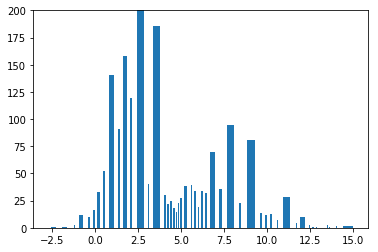

In [11]:
hist = h1 + h2

plt.bar(
    x=[(b.left + b.right) / 2 for b in hist],
    height=[b.count for b in hist],
    width=[(b.right - b.left) / 2 for b in hist]
)

plt.ylim(0, 200);

In [12]:
hist.data[:5]

[[-2.69596, -2.69596]: 1.0,
 [-2.69596, -2.09109]: 1.0,
 [-2.09109, -1.43778]: 1.0,
 [-1.22622, -1.10408]: 3.0,
 [-1.05746, -0.54330]: 12.0]

In [13]:
len(hist)

50

In [14]:
sum(b.count for b in h1 + h2)

2003.0

In [15]:
sum(b.count for b in h)

2000

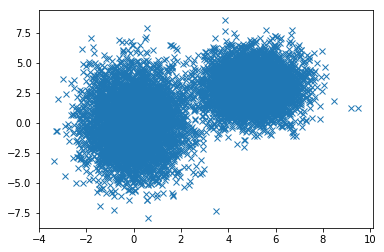

In [16]:
import numpy as np

data = np.vstack([
    np.random.multivariate_normal([0, 0], [[1, 0], [0, 5]], 5000),
    np.random.multivariate_normal([5, 3], [[1, 0], [0, 2]], 5000)
])
    
x, y = data.T
plt.plot(x, y, 'x')
plt.show()

In [17]:
import collections
import textwrap


class Slice:
    """A Slice is an of a MultiHistogram."""

    __slots__ = ['left', 'right', 'hist']

    def __init__(self, left, right, hist):
        self.left = left
        self.right = right
        self.hist = hist
        
    def __iadd__(self, other):
        """Merge with another bin."""
        if other.left < self.left:
            self.left = other.left
        if other.right > self.right:
            self.right = other.right
        self.hist += other.hist
        return self
        
    def __repr__(self):
        return f'[{self.left:.5f}, {self.right:.5f}]:\n\t{self.hist}'


class MultiHistogram(collections.UserList):
    
    def __init__(self, order, max_bins=256):
        super().__init__()
        self.order = order
        self.max_bins = max_bins
        self.n = 0 
        
    def update(self, x):
        
        xi = x[self.order[0]]
        self.n += 1
        
        h = utils.Histogram(max_bins=self.max_bins)
        h.update(x[self.order[-1]])
        s = Slice(xi, xi, h)

        # Insert the bin if the histogram is empty
        if not self:
            self.append(s)
            return self
        
        # Use bisection to find where to insert
        lo = 0
        hi = len(self)
        i = (lo + hi) // 2
        while lo < hi:
            if self[i].right < xi:
                lo = i + 1
            else:
                hi = i
            i = (lo + hi) // 2

        if i == len(self):
            # x is past the right-most bin
            self.append(s)
        else:
            # Increment the bin counter if x is part of the ith bin
            if xi >= self[i].left:
                self[i].hist.update(x[self.order[-1]])
            # Insert the bin if it is between bin i-1 and bin i
            else:
                self.insert(i, s)

        # Bins have to be merged if there are more than max_bins
        if len(self) > self.max_bins:
            self._shrink(1)

        return self
    
    def _shrink(self, k):
        """Shrinks the histogram by merging the two closest bins."""

        indexes = range(len(self) - 1)

        def distance(i):
            return self[i + 1].right - self[i].right

        if k == 1:
            i = min(indexes, key=distance)
            self[i] += self.pop(i + 1)  # Calls Slice.__iadd__
            return

        for i in sorted(heapq.nsmallest(n=k, iterable=indexes, key=bin_distance), reverse=True):
            self[i] += self.pop(i + 1)  # Calls Slice.__iadd__
    
    def __repr__(self):
        return '\n'.join(str(b) for b in self)
        
h = MultiHistogram(order=[0, 1], max_bins=20)

for i, obs in enumerate(data):
    obs = dict(enumerate(obs))
    h.update(obs)
        
len(h.data)

20

In [18]:
for s in h:
    print(s.left, s.right)

-3.374189545901298 -3.1948369944686585
-2.9668946189155485 -2.71837951680391
-2.652937918342111 -2.409709961360021
-2.4080886011161233 -1.2571166779861414
-1.2558857988674614 -0.8374604097488014
-0.8366805227909666 -0.45606217594729553
-0.45534303091465034 0.575660003124806
0.5777945327592764 1.2750815020440394
1.2758071909112476 1.8511699450853971
1.8584027017886493 2.773675547702391
2.79465713421882 3.2797606501785097
3.2839813782396607 3.772147853522918
3.7722840073600303 4.828715975431106
4.829529004303061 5.4240837087942815
5.4246463380539796 6.259240237409565
6.259301291519424 7.116979919403295
7.117576103508241 7.758515386975743
7.86707121787045 8.115525461185149
8.46777697457411 8.46777697457411
9.207500654608715 9.492865916808649


(-8.5, 10)

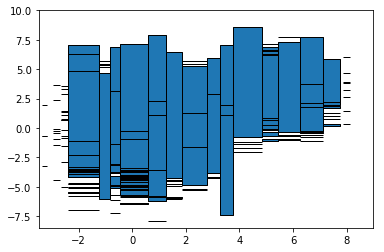

In [19]:
from matplotlib import collections 
from matplotlib import patches

fig, ax = plt.subplots(1)

rectangles = []

for s in h:
    for b in s.hist:
        xy = (s.left, b.left)
        width = s.right - s.left
        height = b.right - b.left
        rect = patches.Rectangle(xy, width, height)
        rectangles.append(rect)
        
pc = collections.PatchCollection(rectangles, edgecolor='k')
ax.add_collection(pc);
ax.set_xlim(-3.5, 9)
ax.set_ylim(-8.5, 10)

In [1]:
from creme import utils

hist = utils.Histogram()
for x in range(4):
    hist = hist.update(x)

print(hist)

[0.00000, 0.00000]: 1
[1.00000, 1.00000]: 1
[2.00000, 2.00000]: 1
[3.00000, 3.00000]: 1


In [6]:
from creme.utils.histogram import Bin
import math

def iter_cdf(hist, X):

    bins = iter(hist)
    b = next(bins)
    INF = Bin(math.inf, math.inf, 0)
    
    cdf = 0
    
    for x in X:
        
        while x >= b.right:
            cdf += b.count
            b = next(bins, INF)
            
        if x > b.left:
            cdf += b.count * (x - b.left) / (b.right - b.left)
            
        yield cdf / hist.n
            

X = [-1, 0, 0.5, 1, 2.5, 3, 5]

for x, cdf in zip(X, iter_cdf(hist, X)):
    print(x, cdf)

-1 0.0
0 0.25
0.5 0.25
1 0.5
2.5 0.75
3 1.0
5 1.0


In [8]:
%timeit list(iter_cdf(hist, X))

         33 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        8    0.000    0.000    0.000    0.000 <ipython-input-6-11bc1491033c>:4(iter_cdf)
        5    0.000    0.000    0.000    0.000 __init__.py:1094(__getitem__)
        5    0.000    0.000    0.000    0.000 _collections_abc.py:879(__iter__)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        5    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        5    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        1    0.000    0.000    0.000    0.000 histogram.py:15(__init__)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [61]:
%timeit [hist.cdf(x) for x in X]

21 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
a = iter([1, 2])

next(a) if False else 5

5

In [11]:
next(a)

1